In [7]:
import sys
sys.path.append('/home/rwb/github/skaworkflows')

import logging
import json

from pathlib import Path


logging.basicConfig(level='INFO')
LOGGER = logging.getLogger(__name__)
%pwd 
%cd ../

/home/rwb/github/thesis_experiments/chapter3


In [9]:
system_config_path = Path('workflow_data_allocation/no_data_low_sdp_config_prototype_n896_896channels.json')

with open(system_config_path) as fp: 
    system_config = json.load(fp)

flops,compute_bandwidth,memory = system_config['cluster']['system']['resources']['GenericSDP_m0'].values()
print(flops/10**12, compute_bandwidth/10**9)


10.726 7.5304827


In [10]:
# Setup multipler for a given observation
obs_time = 18000
compute_unit = 10**15 # Peta flop
data_unit = 10**6 # per million visibilites 
bytes_per_vis = 12 

In [194]:
# Isolate a single unit of computing 

import pandas as pd
workflows = ['ICAL', 'DPrepA','DPrepB','DPrepC','DPrepD']
low_hpsos = ['hpso01', 'hpso02a', 'hpso02b']


# structure the data according to | product | workflow | time | type (long-form data) rather than wide form

df = pd.DataFrame()

for wf in workflows: 
    for hpso in low_hpsos:
        hpso_df = pd.DataFrame()
        workflow_data_path = Path(
            f"low/prototype/workflows/data_overview/{hpso}_time-18000_channels-896_tel-512.json_{wf}_data"
        )
        with open(workflow_data_path) as fp: 
            workflow_data = json.load(fp)

        for product in workflow_data:
            columns = {'HPSO': hpso, 'Product': product, 'Workflow': wf, 'Time (s)': [], 'Type': []}
            curr_product_dict = workflow_data[product]
            if 'total_compute' in workflow_data[product]:
                compute = curr_product_dict['fraction_compute_cost']  * obs_time * compute_unit
                columns['Time (s)'].append(compute / flops)
                columns['Type'].append('compute')
                data = curr_product_dict['fraction_data_cost'] * obs_time * data_unit * bytes_per_vis
                columns['Time (s)'].append(data / compute_bandwidth)
                columns['Type'].append('data')
            tmp_df = pd.DataFrame(columns,)
            hpso_df = hpso_df.append(tmp_df, ignore_index=True)
        df = df.append(hpso_df, ignore_index=True)

df[(df['Workflow'] == 'ICAL') & (df['Type'] == 'compute')]

,HPSO,Product,Workflow,Time (s),Type
0,hpso01,UpdateLSM,ICAL,3.308153,compute
2,hpso01,Average,ICAL,0.000000,compute
4,hpso01,Predict,ICAL,2472.734634,compute
6,hpso01,Solve,ICAL,147.051586,compute
8,hpso01,Correct,ICAL,248.016985,compute
10,hpso01,Subtract,ICAL,0.073815,compute
12,hpso01,Flag,ICAL,24.026645,compute
14,hpso01,IFFT,ICAL,359.977355,compute
16,hpso01,Degrid,ICAL,220.057046,compute
18,hpso01,FFT,ICAL,71.995471,compute


In [12]:
# df[df["HPSO"] == 'hpso02b']
df = df.loc[(df!=0).all(1)]
products = set(df["Product"])
products

{'Correct',
 'Degrid',
 'FFT',
 'Flag',
 'Grid',
 'IFFT',
 'Predict',
 'Solve',
 'Subtract',
 'UpdateLSM'}

In [195]:

grouped = df.groupby(["HPSO", "Product"])

# for name, group in grouped:
# #     print(name)
# #     print(group)
    
# df_grouped_ex = grouped.get_group(("hpso01", "Correct"))
# mask = df_grouped_ex['HPSO']== df_grouped_ex['HPSO']
# mid_group = df_grouped_ex.groupby(["Type"])

# mid_group.get_group("data")
# for name, group in mid_group:
#     print(name)
#     print(group)

# min_time = min(
#     grouped.get_group(("hpso01", "Correct", "compute")).min()['Time (s)'],
#     grouped.get_group(("hpso01", "Correct", "data")).min()['Time (s)']
# )
# max_time = 
# df_grouped_ex.loc[:, "rank"] = df_grouped_ex.max()["Time (s)"] - df_grouped_ex.min()["Time (s)"]
# df_grouped_ex

hpso_dataframes = {}
for h in low_hpsos:
    df_hpso = df[df["HPSO"] == h]
    grouped = df_hpso.groupby("Product")
    grouped_df = []
    
    for p in products:
        if p not in grouped.groups.keys():
            continue
        df_grouped_ex = grouped.get_group(p)
        tmp_group = df_grouped_ex.groupby(["Type"])
        min_time = min(
            tmp_group.get_group("data").min()["Time (s)"],
            tmp_group.get_group("compute").min()["Time (s)"] 
        )
        max_time = max(
            tmp_group.get_group("data").max()["Time (s)"],
            tmp_group.get_group("compute").max()["Time (s)"] 
        )
        df_grouped_ex.loc[:, "rank"] = max_time-min_time
        grouped_df.append(df_grouped_ex)
    if grouped_df:
        hpso_dataframes[h] = pd.concat(grouped_df, ignore_index=True)

hpso_dataframes['hpso01'] = hpso_dataframes['hpso01'].sort_values(by=['rank','Product'], ascending=False)
# hpso_dataframes

/home/rwb/github/topsim/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


KeyError: 'compute'

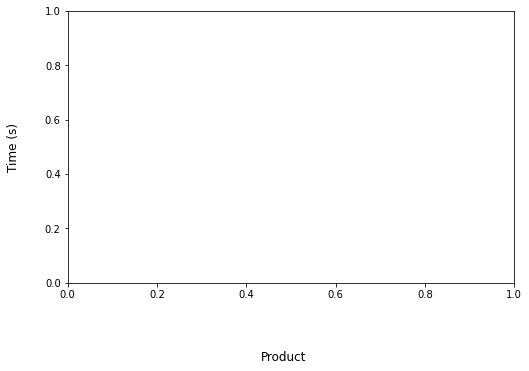

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))


fig.supxlabel('Product', y=-0.1), fig.supylabel('Time (s)')

# Look into representing this as something like a distribution across all workflows
# Seaborn categorical scatterplots could be a good start: https://seaborn.pydata.org/tutorial/categorical.html#categorical-scatterplots

x_label = df['Product']
x_compute = df['compute']/(flops)
x_data = df['data']/(compute_bandwidth)
x = np.arange(0, 2*len(x_label), step=2)

ax.bar(x - 0.5, x_compute,log=True,zorder=1)
ax.bar(x + 0.5, x_data)
ax.set_xticks(x, x_label,rotation='vertical')
ax.tick_params(right=True, top=True, which='both', direction='in')
plt.savefig('output.png')

/tmp/ipykernel_93428/1241279333.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("HPSORuntimeComparison.png")
/tmp/ipykernel_93428/1241279333.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("HPSORuntimeComparison.png")
/tmp/ipykernel_93428/1241279333.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("HPSORuntimeComparison.png")
/tmp/ipykernel_93428/1241279333.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two m

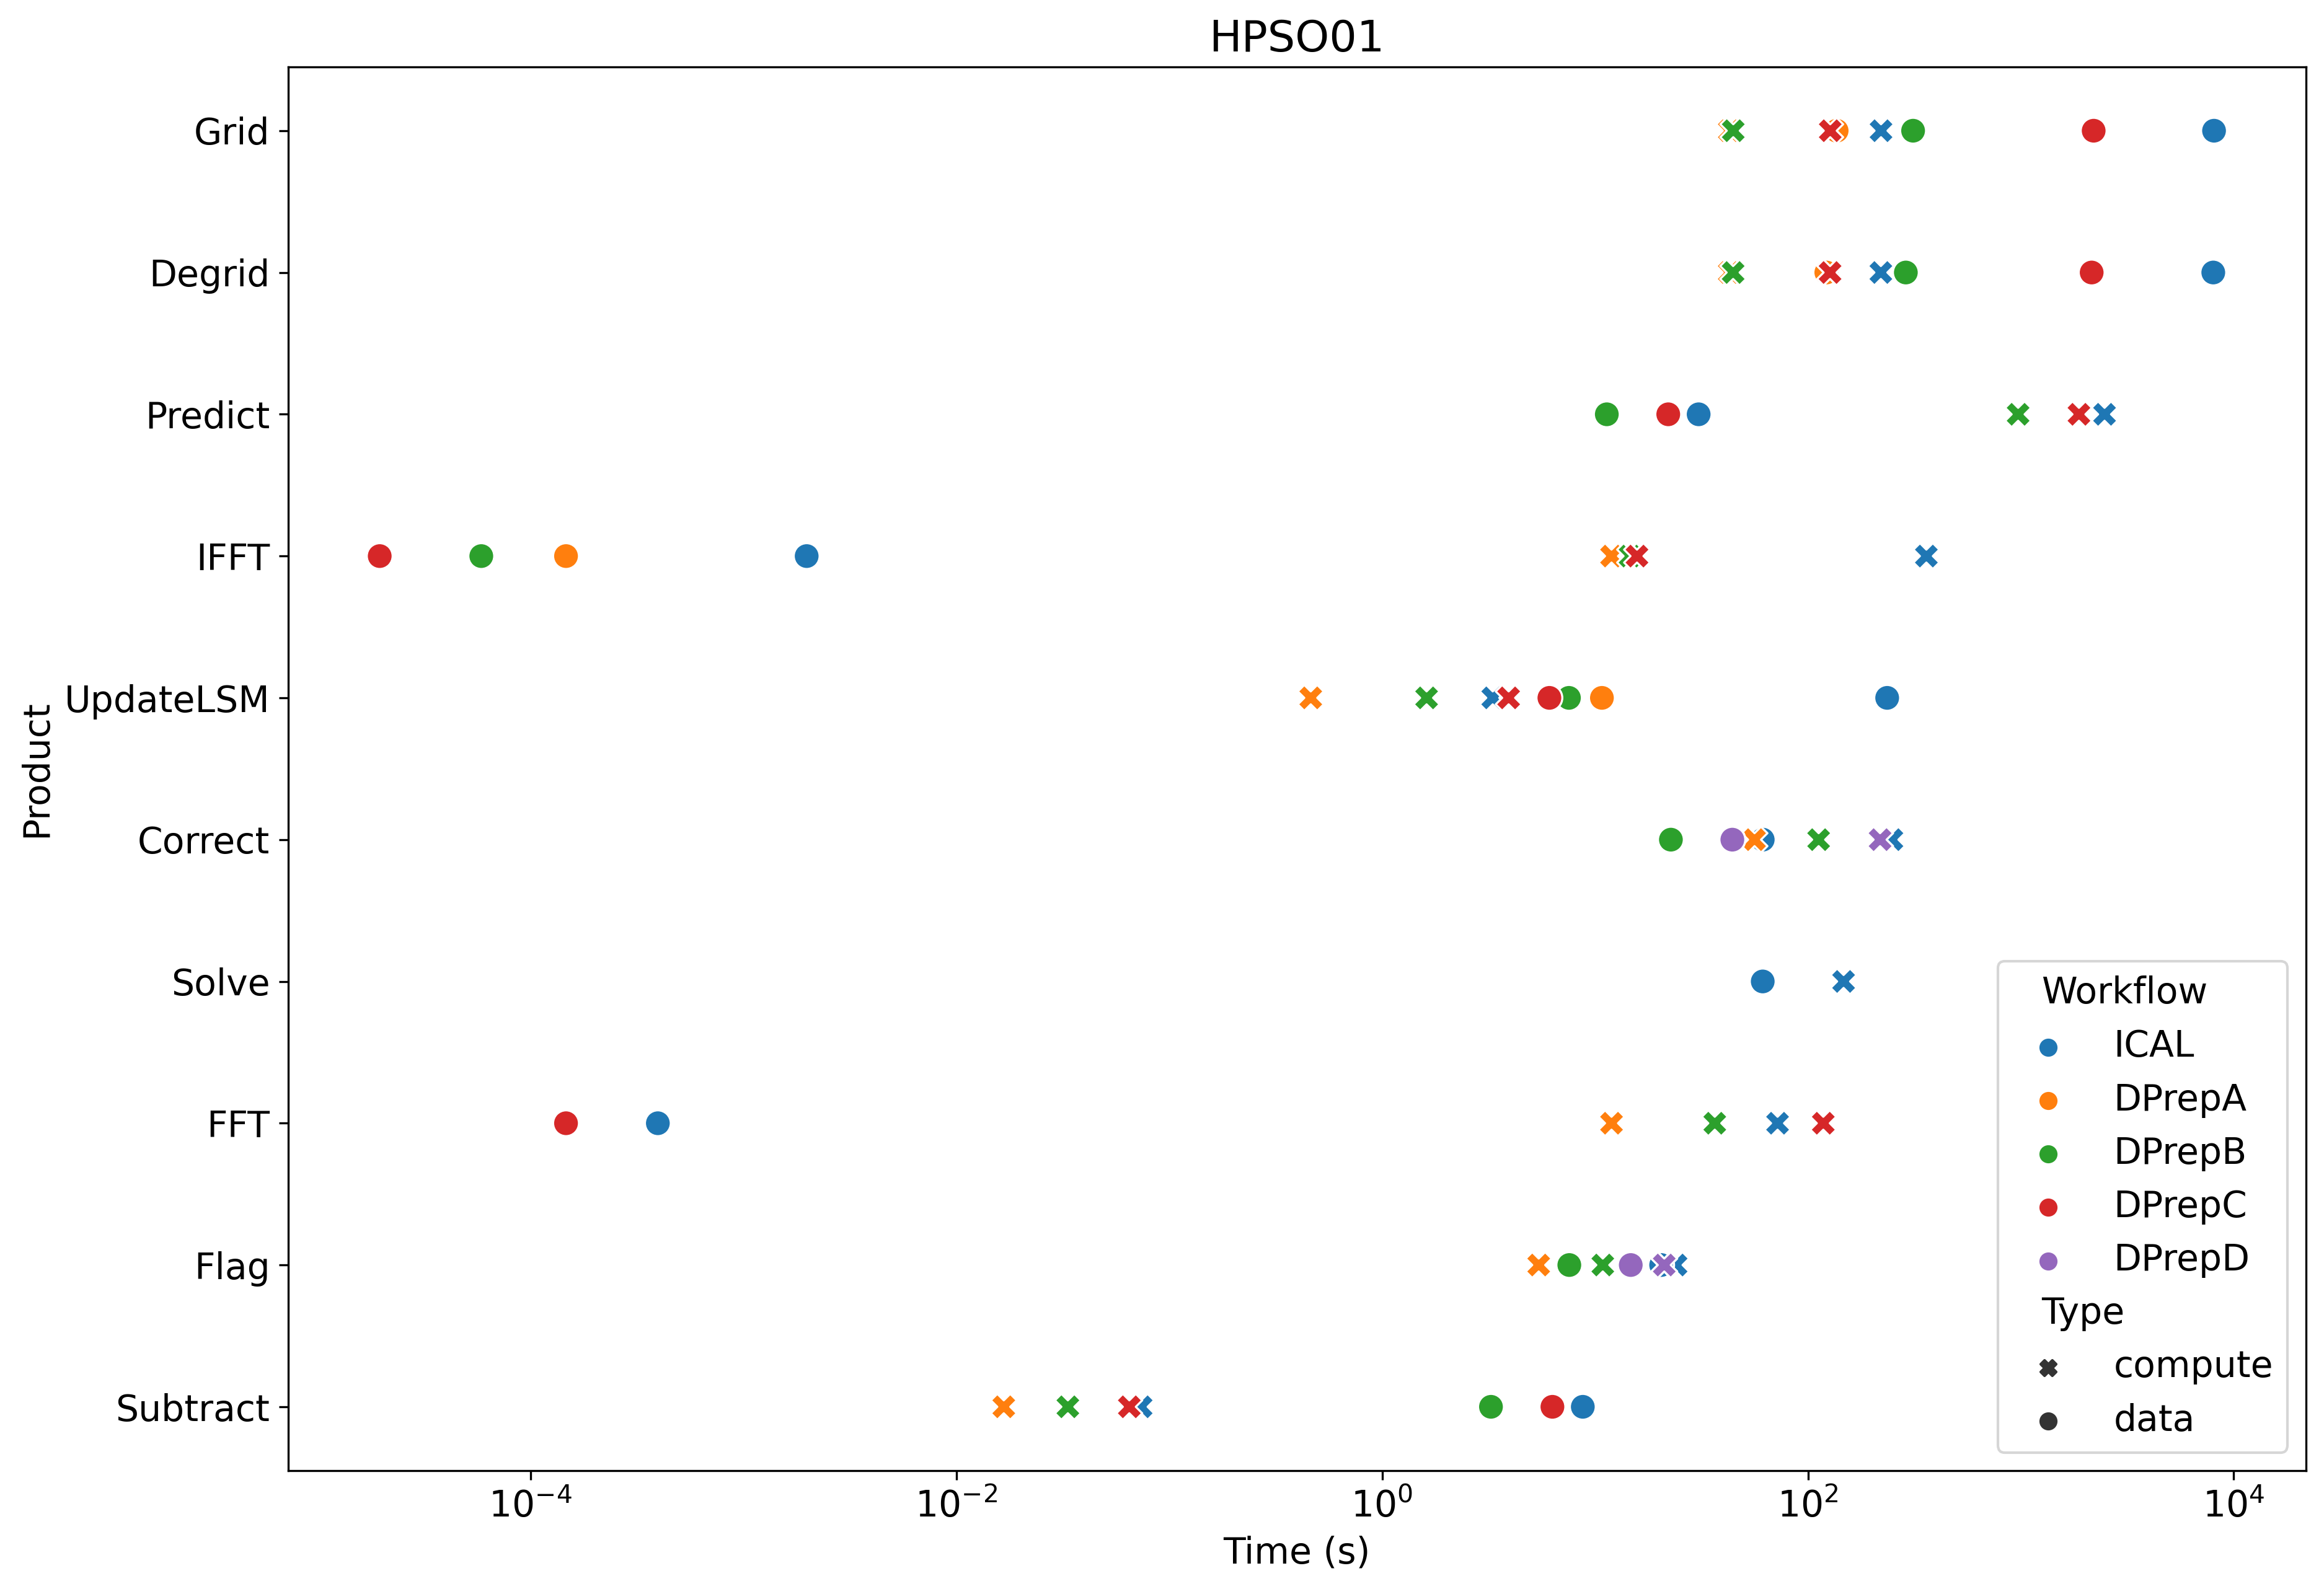

In [196]:
# For categorical plot, we want to reshape the data so the time is either compute or data
# i.e. rather than Product| workflow | Data time | compute time | , we have | product | workflow | time | type 
plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(14,10),dpi=300)

hpso = 'hpso01'
df = hpso_dataframes[hpso]

df_comp = df[df['Type']== 'compute']
df_data = df[df['Type']== 'data']

g = sns.scatterplot(df, y='Product', x='Time (s)', hue='Workflow', style='Type', markers=['X', 'o'], s=100,)
# g = sns.catplot(df_data, y='Product', x='Time (s)', hue='Workflow', s=8, jitter=False, marker='P')
g.set_xscale("log")
# g.set_facecolor("none")
ax.set_title("HPSO01")
# for ax in g.fig.axes:
#     ax.set_xscale("log"))

plt.savefig("HPSORuntimeComparison.png")

/tmp/ipykernel_93428/694879904.py:3: RuntimeWarning: invalid value encountered in true_divide
  df_comp.loc[:, "ratio"] = (np.array(df_data['Time (s)']) / np.array(df_comp['Time (s)']))
/home/rwb/github/topsim/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


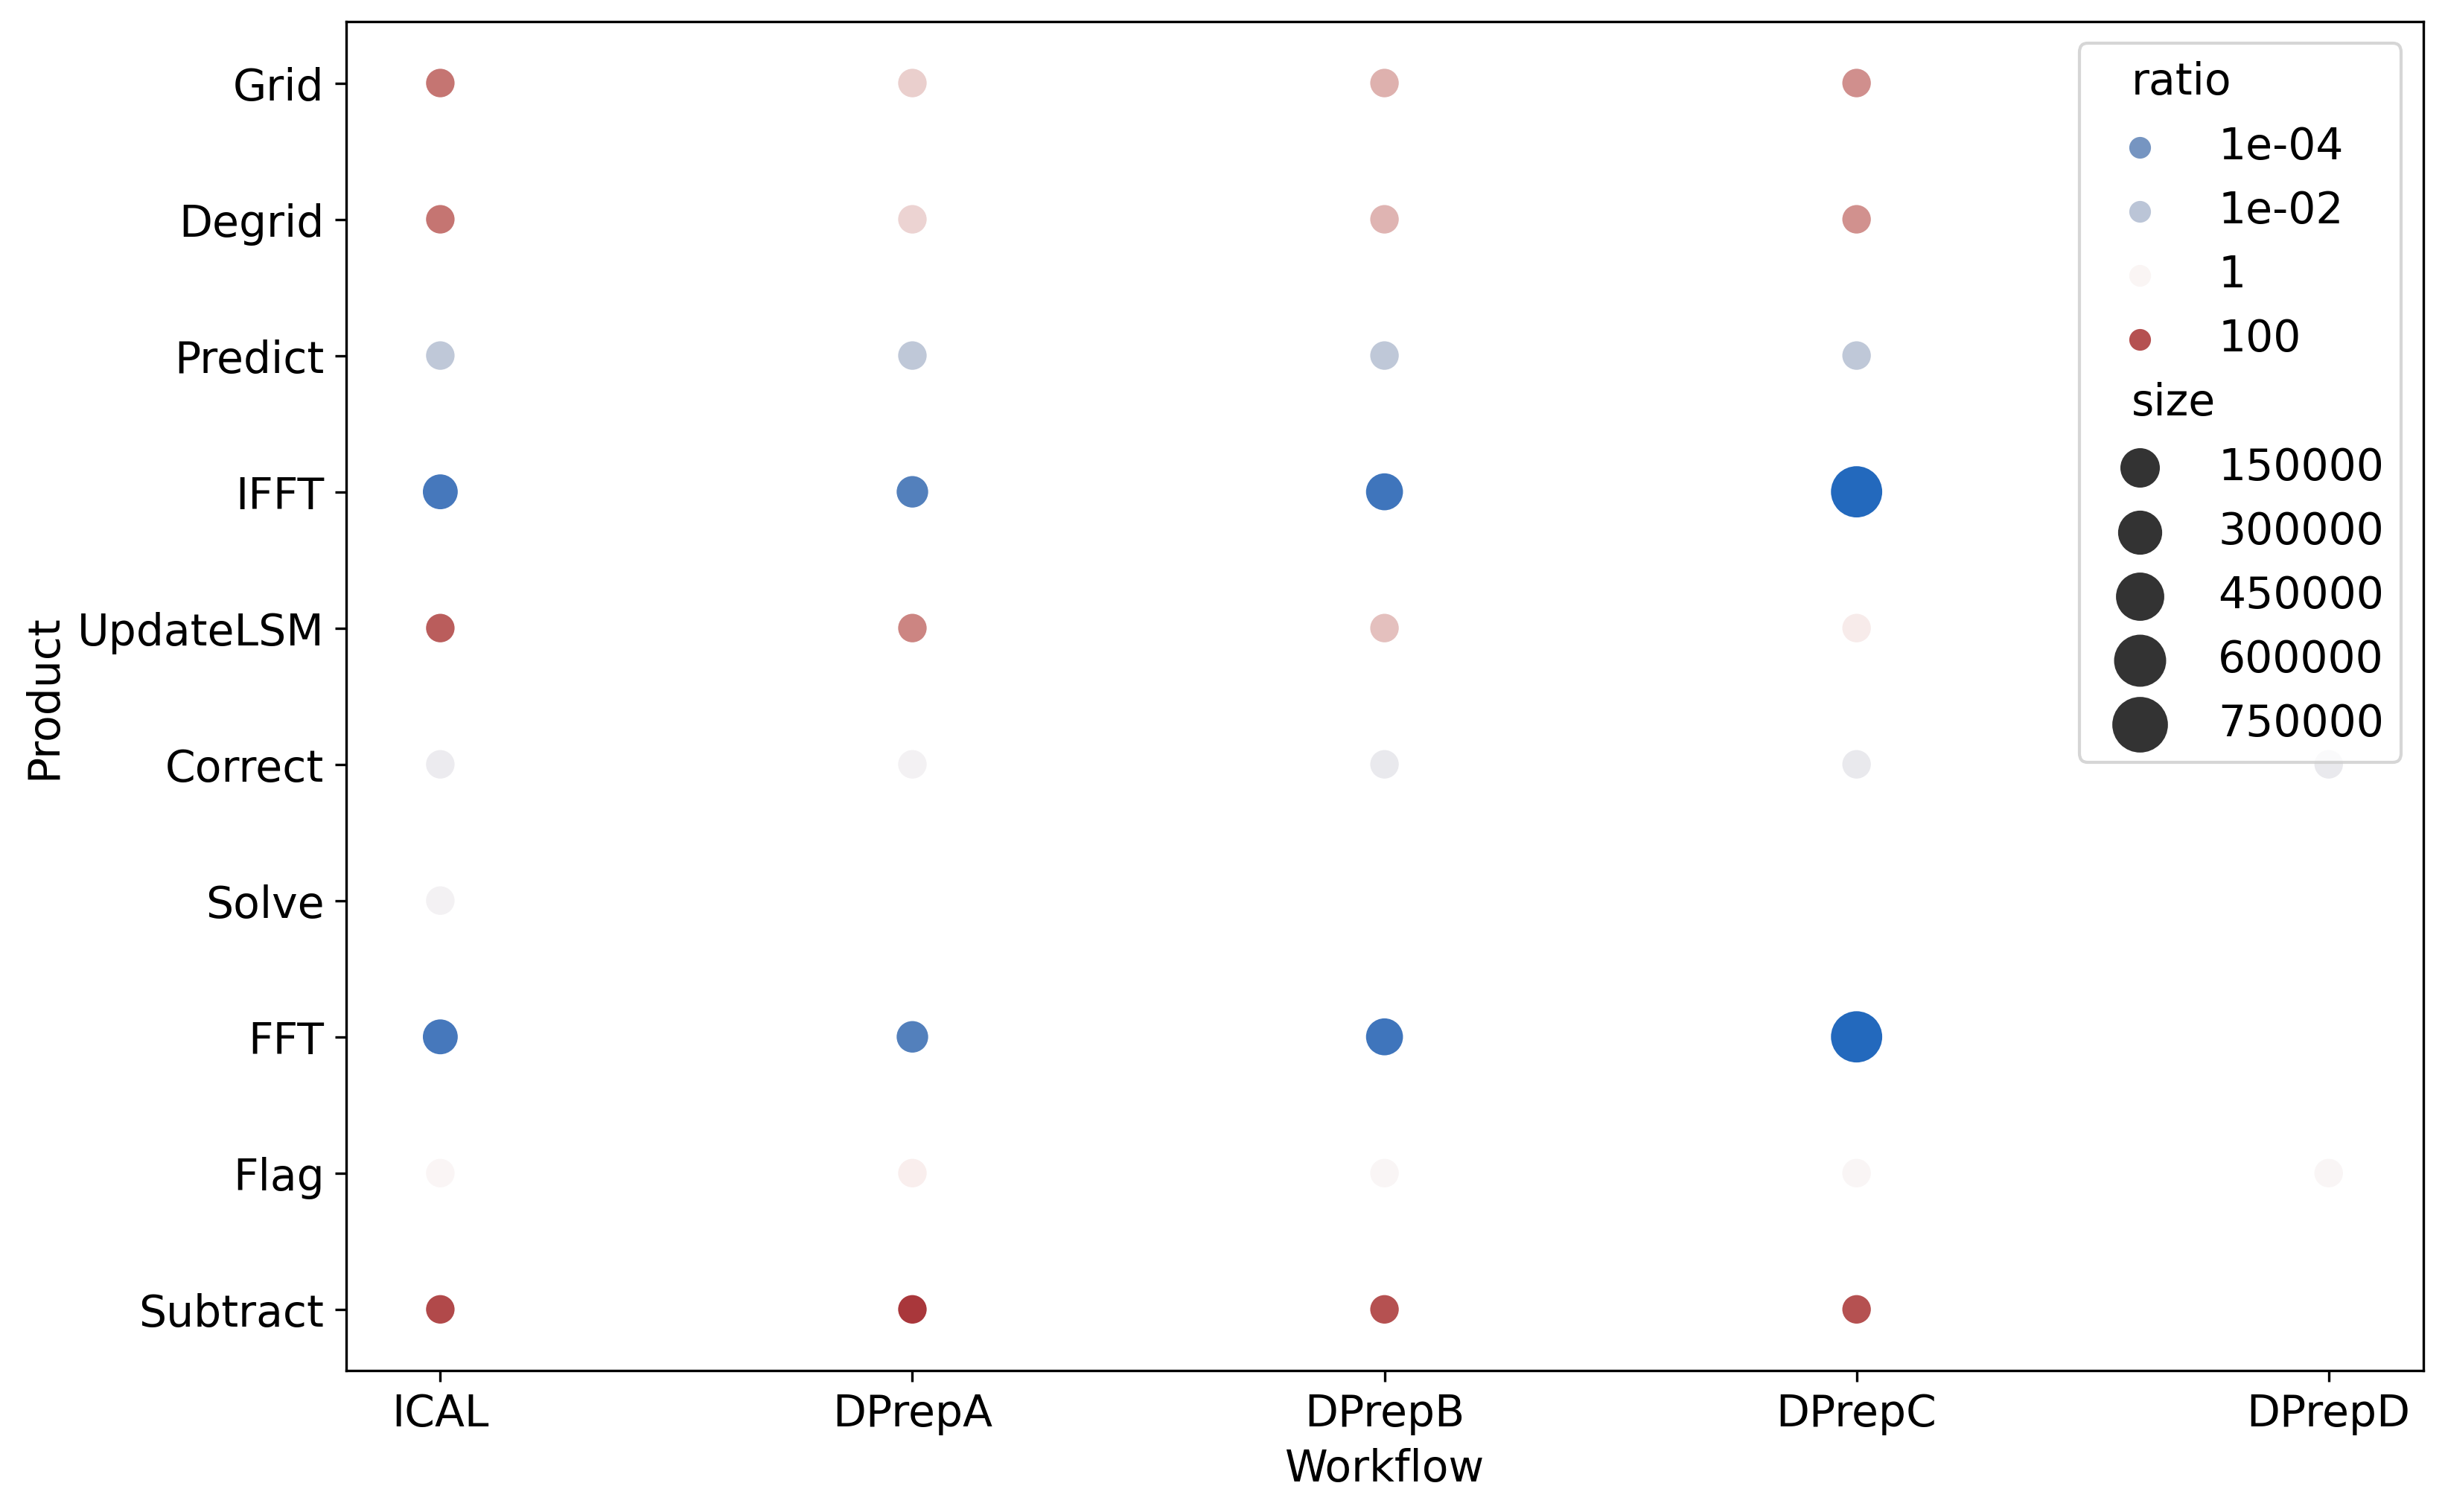

In [315]:
from matplotlib.colors import CenteredNorm, LogNorm
from matplotlib import cm
df_comp.loc[:, "ratio"] = (np.array(df_data['Time (s)']) / np.array(df_comp['Time (s)']))

df_comp.loc[:, "size"] = [( c/1 if c/1 > 1 else 1/c) for c in df_comp['ratio']]

f, ax = plt.subplots(figsize=(12,8),dpi=300)

class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

colorpalette = 'vlag'
norm = MidPointLogNorm(vmin=df_comp['ratio'].min(), vmax=df_comp['ratio'].max(),midpoint=1)
# norm = LogNorm(vmin=df_comp['ratio'].min(), vmax=df_comp['ratio'].max()) # plt.Normalize(df_comp['ratio'].min(), df_comp['ratio'].max())
# norm = CenteredNorm(vcenter=1,halfrange=df_comp['ratio'].max())
sm = plt.cm.ScalarMappable(cmap=colorpalette, norm=norm)
# sm.set_array([])


v = sns.scatterplot(
    df_comp, y='Product', x='Workflow',  hue='ratio', size='size', sizes=(100,300),
    palette=colorpalette, legend="brief" , hue_norm=norm,ax=ax)
norm

In [ ]:
from matplotlib.colors import CenteredNorm, LogNorm, TwoSlopeNorm, Normalize
from matplotlib import cm
df_comp.loc[:, "ratio"] = ((np.array(df_data['Time (s)']) / np.array(df_comp['Time (s)'])))

df_comp.loc[:, "size"] = [( c/1 if c/1 > 1 else 1/c) for c in df_comp['ratio']]

f, ax = plt.subplots(figsize=(12,8),dpi=300)

class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

    def inverse(self, value):
        y, x = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.interp(value, x, y, left=-np.inf, right=np.inf)
    
    
colorpalette = 'vlag'
norm = LogNorm(vmin=0.001, vmax=1000)
# midnorm = MidpointNormalize(0, vmax=df_comp['ratio'].max(),vcenter=50)
x = df_comp['Workflow']
y = df_comp['Product']

# norm = TwoSlopeNorm( vcenter=1, vmin=df_comp['ratio'].min(), vmax=200) # , vmin=df_comp['ratio'].min(), vmax=df_comp['ratio'].max())
res = ax.scatter(x,y , c=df_comp['ratio'], s=df_comp['size'], sizes=(100,150), cmap=colorpalette, norm=norm)
cb = f.colorbar(res)
# f.colorbar(v, ax=ax)
# cb = ax.figure.colorbar(res)
# cb.ax.set_yscale('log')
# cb.set_ticks([0,1.0, 25.0])
# cb.

/tmp/ipykernel_93428/679989425.py:3: RuntimeWarning: invalid value encountered in true_divide
  df_comp.loc[:, "ratio"] = ((np.array(df_data['Time (s)']) / np.array(df_comp['Time (s)'])))
/home/rwb/github/topsim/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


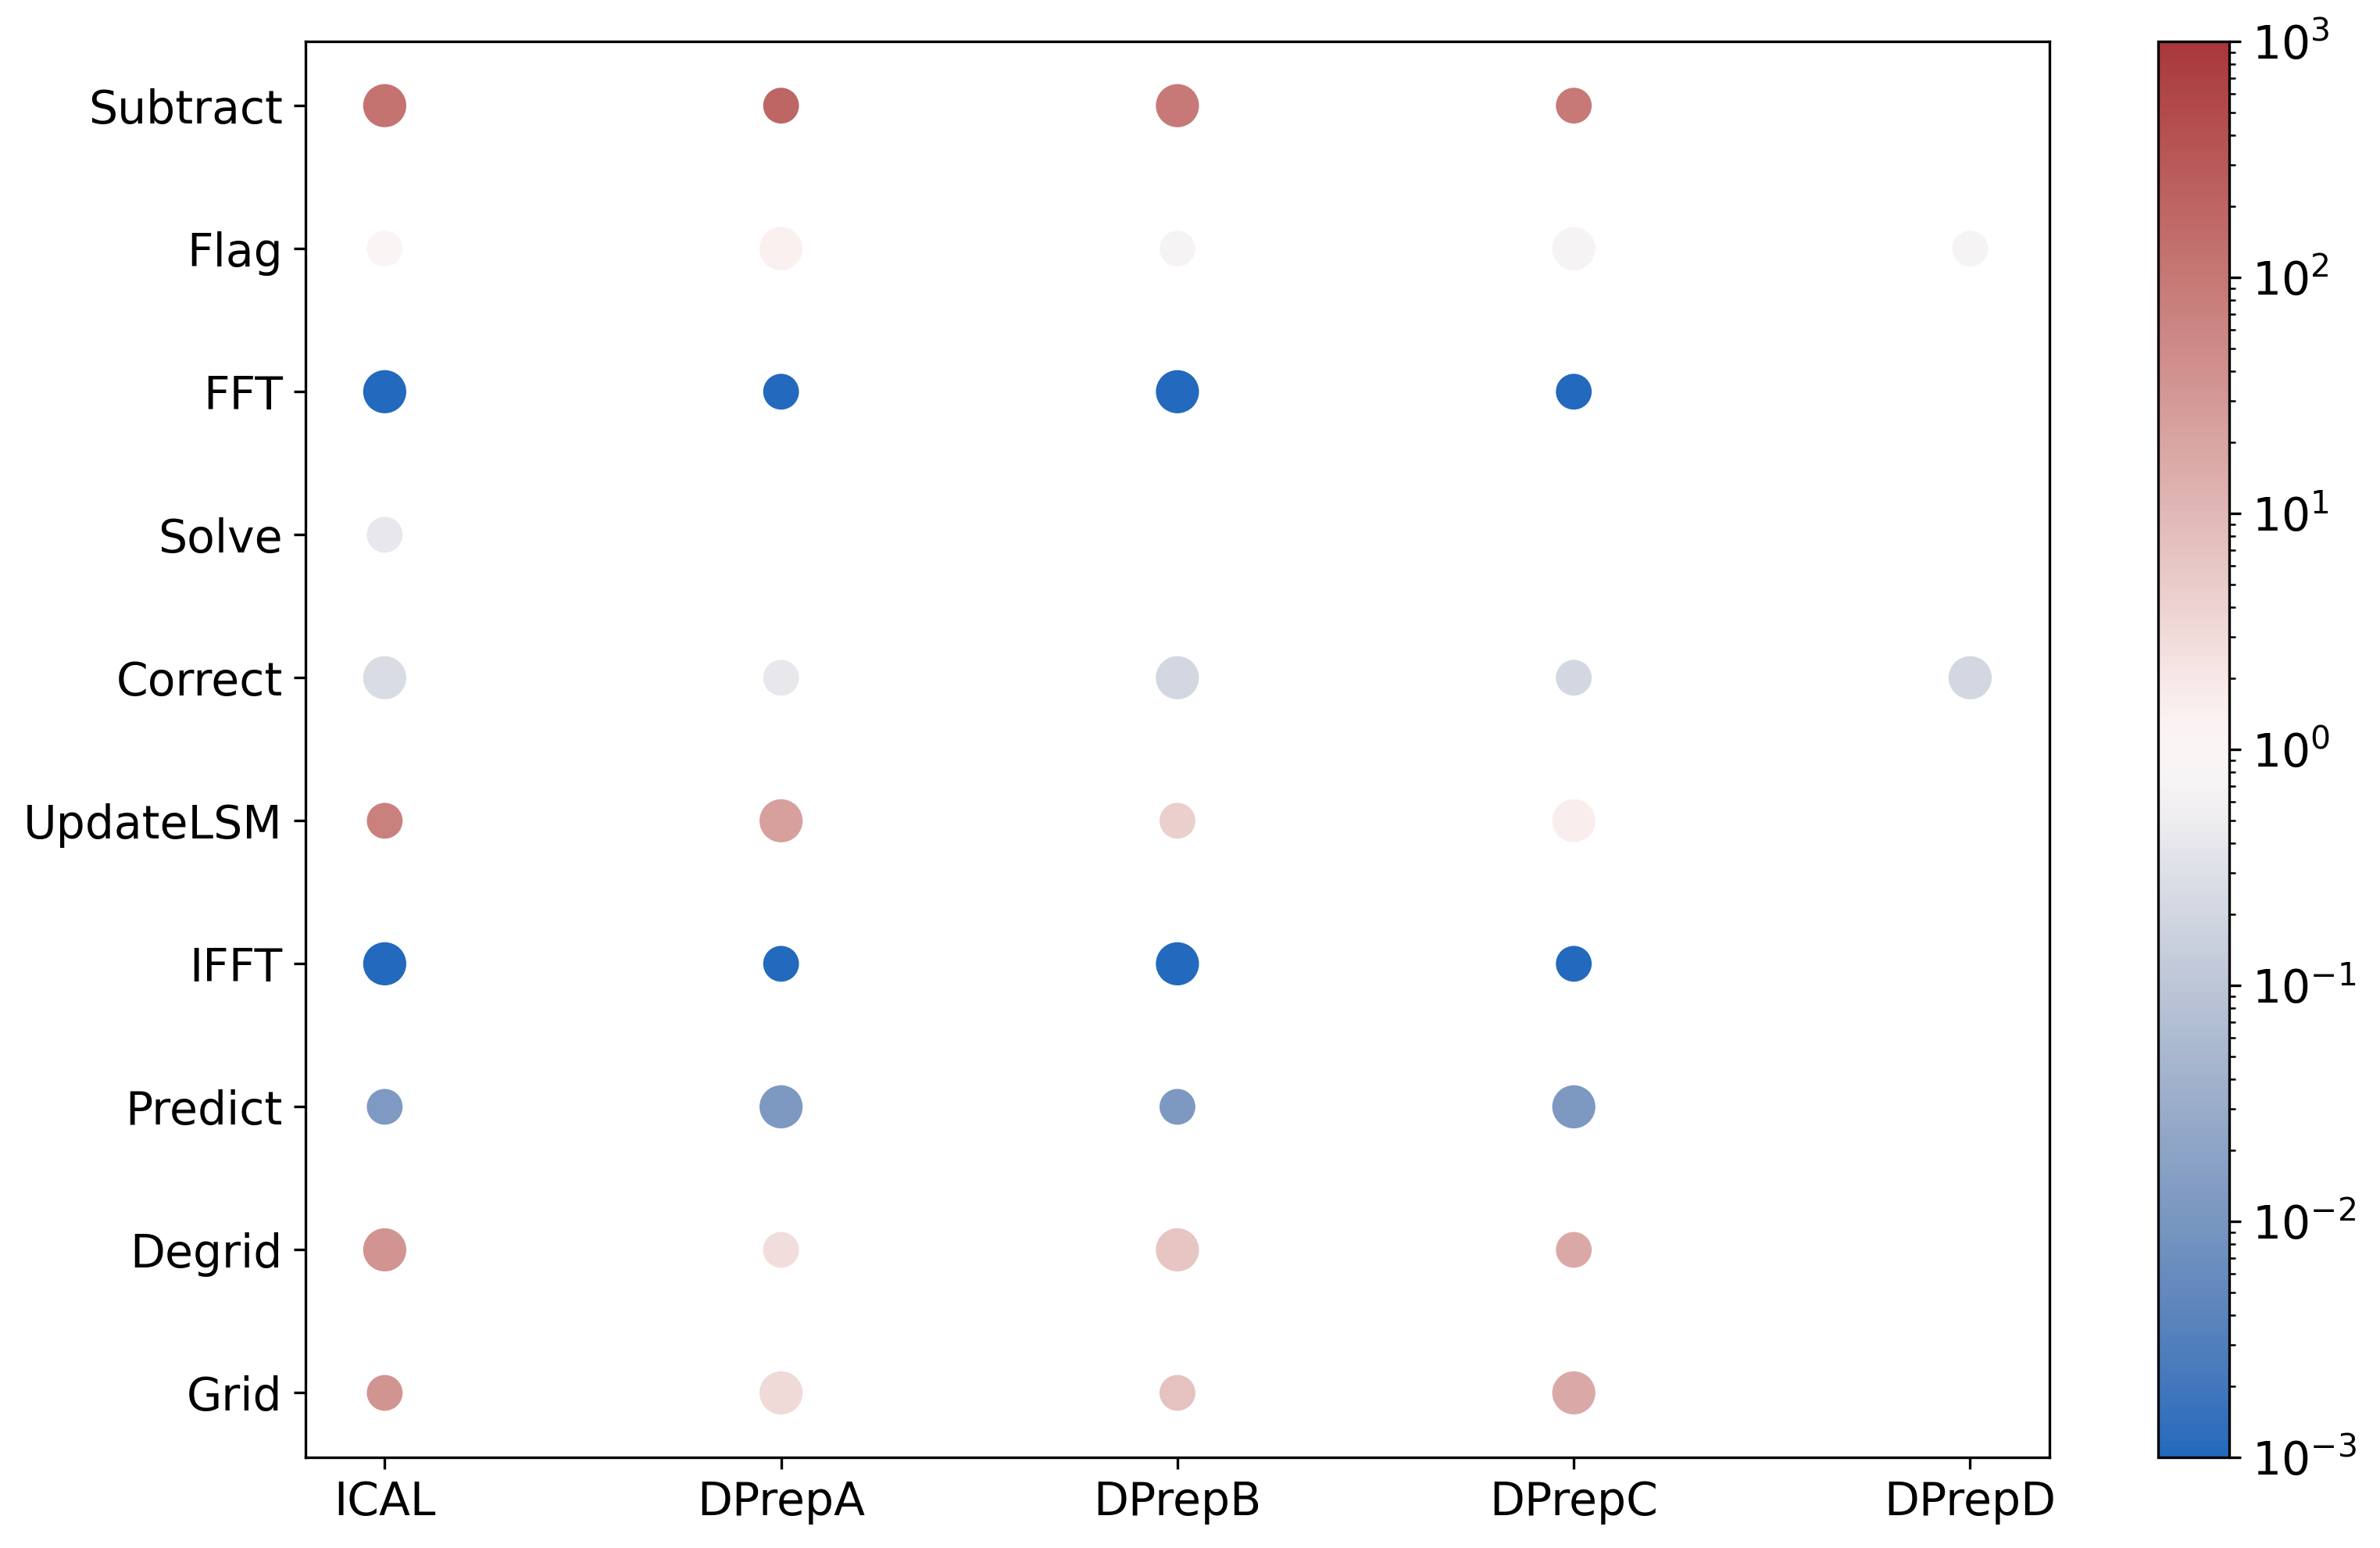

In [456]:
df_comp['size']

In [151]:
df_comp['size']

24        36.661692
26         3.191988
28         6.993168
30        17.271990
0         36.420542
2          2.857057
4          6.475623
6         16.934260
8         80.631645
10        85.259778
12        85.493956
14        84.921561
62    181626.442985
64     81417.075387
66    248707.220270
68    804234.403082
16        71.217214
18        23.307452
20         4.661490
22         1.553830
32         4.043966
34         2.471313
36         4.942625
38         4.942625
40         4.942625
70    181626.442985
72     81417.075387
74    248707.220270
76    804234.403082
60         2.397705
50         1.175278
52         1.392321
54         1.436450
56         1.436450
58         1.436450
42       118.695357
44       194.228766
46        97.114383
48        97.114383
Name: size, dtype: float64